In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle

In [76]:
import tensorflow as tf
import kaggle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as k
import torch
import torchvision.models as models
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import matplotlib.image as mi
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
%matplotlib inline
import os

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:28<00:00, 33.5MB/s]
100% 812M/812M [00:28<00:00, 29.9MB/s]


In [ ]:
!unzip -q train.zip

In [54]:
data = []
label = []

for i in os.listdir('train/'):
  #print(i)
  if i.startswith('cat'):
    label.append('cat')
  else:
    label.append('dog')
  data.append('train/'+i)

In [55]:
data[:5]

['train/dog.5875.jpg',
 'train/dog.3234.jpg',
 'train/cat.5243.jpg',
 'train/dog.4898.jpg',
 'train/dog.8054.jpg']

In [56]:
label[:5]

['dog', 'dog', 'cat', 'dog', 'dog']

In [57]:
dic = {'data':data,'label':label}

In [58]:
data = pd.DataFrame(dic)

In [59]:
data.head()

,data,label
0,train/dog.5875.jpg,dog
1,train/dog.3234.jpg,dog
2,train/cat.5243.jpg,cat
3,train/dog.4898.jpg,dog
4,train/dog.8054.jpg,dog


In [60]:
data.shape

(25000, 2)

In [61]:
train_data = data[:23000]
test_data = data[23000:]

In [62]:
test_data.shape

(2000, 2)

In [63]:
img_w = 256
img_h = 256

In [64]:
if k.image_data_format() == 'channels_first':
    input_shape = (3,img_w,img_h)
else:
    input_shape = (img_w,img_h,3)

In [65]:
input_shape

(256, 256, 3)

## Image Generation to Train Data

In [66]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_data,target_size=(img_w,img_h),x_col='data',y_col='label',subset='training',
                                                    class_mode='binary')
val_generator = train_datagen.flow_from_dataframe(train_data,target_size=(img_w,img_h),x_col='data',y_col='label',subset='validation',
                                                 class_mode='binary')
test_generator = test_datagen.flow_from_dataframe(test_data,target_size=(img_w,img_h),x_col='data',y_col='label',class_mode='binary')

Found 19550 validated image filenames belonging to 2 classes.
Found 3450 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [67]:
train_generator[0][0].shape

(32, 256, 256, 3)

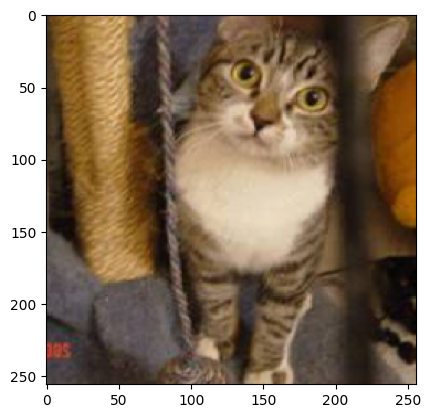

In [68]:
#print(train_generator[0][0].shape)
plt.imshow(train_generator[0][0][3])

## Unfolding ImageDataGenerator

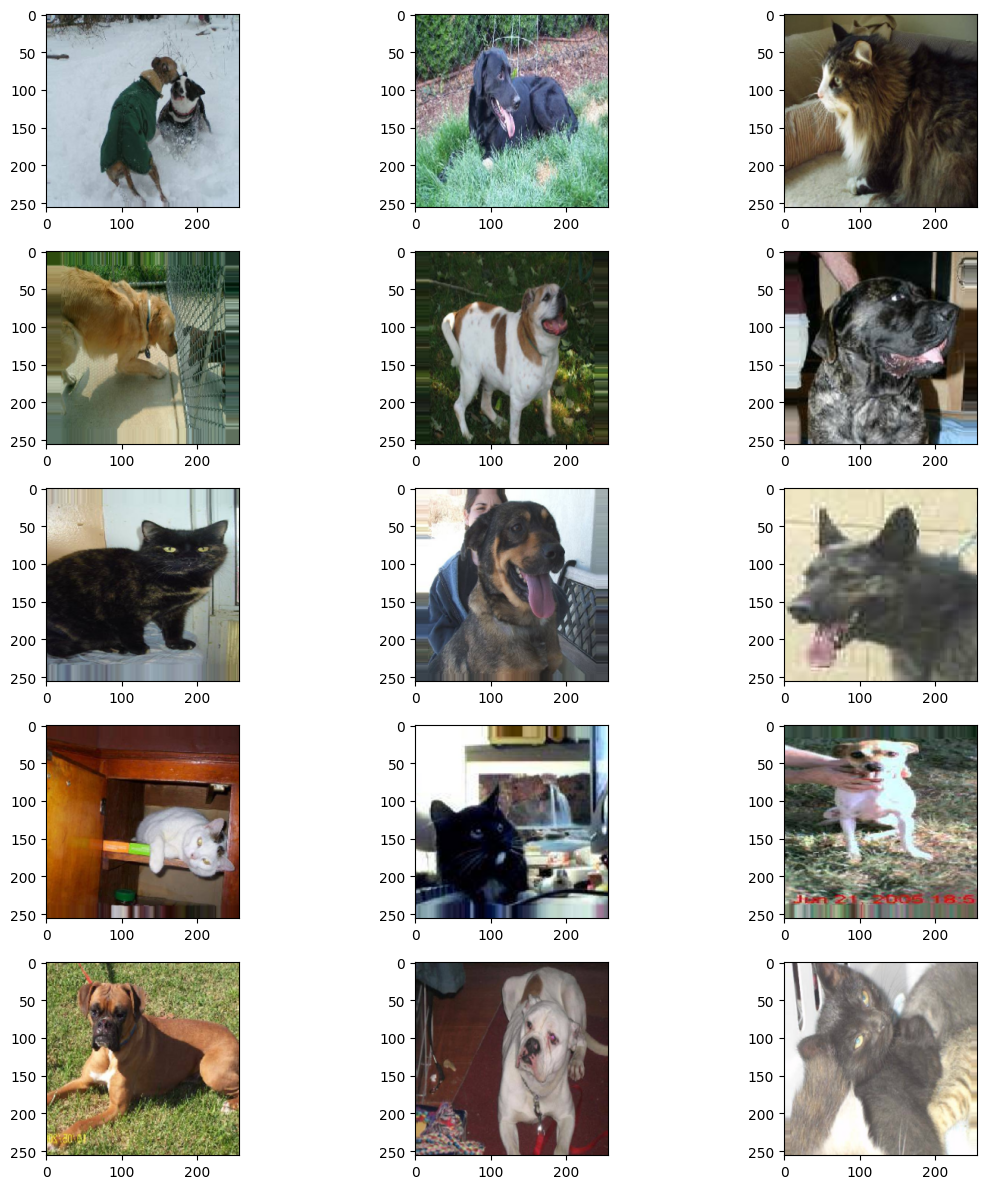

In [69]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)

    for x_batch,y_batch in train_generator:
        i1 = x_batch[0]
        #s1 = x_batch[0].shape
        plt.imshow(i1)
        break
plt.tight_layout()
plt.show()
#print(s1)

In [70]:
#l1 = []
#for x_batch,y_batch in train_generator:
    #l1.append(y_batch)

## Model Building

In [71]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

In [72]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_generator,epochs=20,batch_size=64,validation_data=val_generator)

Epoch 1/20
611/611 [==============================] - 407s 660ms/step - loss: 1.5479 - accuracy: 0.5885 - val_loss: 0.6922 - val_accuracy: 0.5965
Epoch 2/20
611/611 [==============================] - 398s 651ms/step - loss: 0.5923 - accuracy: 0.6886 - val_loss: 0.5268 - val_accuracy: 0.7270
Epoch 3/20
611/611 [==============================] - 414s 677ms/step - loss: 0.5160 - accuracy: 0.7471 - val_loss: 0.6749 - val_accuracy: 0.6238
Epoch 4/20
611/611 [==============================] - 385s 630ms/step - loss: 0.4631 - accuracy: 0.7833 - val_loss: 0.5211 - val_accuracy: 0.7299
Epoch 5/20
611/611 [==============================] - 392s 641ms/step - loss: 0.4339 - accuracy: 0.8051 - val_loss: 0.4268 - val_accuracy: 0.7928
Epoch 6/20
611/611 [==============================] - 387s 634ms/step - loss: 0.4096 - accuracy: 0.8211 - val_loss: 0.4993 - val_accuracy: 0.7536
Epoch 7/20
611/611 [==============================] - 387s 633ms/step - loss: 0.3695 - accuracy: 0.8403 - val_loss: 0.4428 -

In [ ]:
model.evaluate(test_generator)

63/63 [==============================] - 10s 154ms/step - loss: 0.3628 - accuracy: 0.8720


[0.36278071999549866, 0.871999979019165]

In [ ]:
model.save('my_model.h5')

## Image Prediction

In [82]:
pred = model.predict(test_generator)

print(pred)

AttributeError: ignored

In [ ]:
threshold = 0.5

binary_pred = (pred > threshold).astype(int)

print(binary_pred)

[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]


In [ ]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

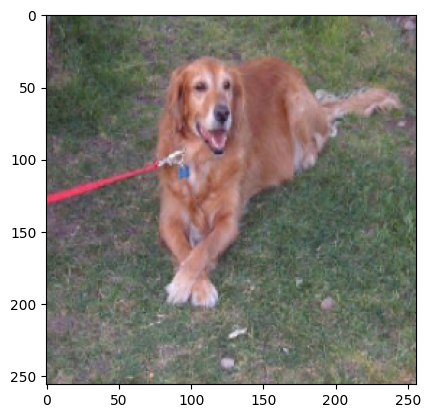

In [ ]:
plt.imshow(train_generator[0][0][19])

In [ ]:
input_sample = train_generator[0][0][19]

input_sample_reshaped = np.expand_dims(input_sample, axis=0)

pred = model.predict(input_sample_reshaped)

if pred < 0.5:
  print('cat')
else:
  print('dog')


1/1 [==============================] - 0s 27ms/step
dog


VGG Model

In [ ]:
vgg_model = VGG16(include_top=False,input_shape=(256,256,3))

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for i in vgg_model.layers:
    i.trainable = False

In [ ]:
vgg_output = vgg_model.output
vgg_output

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
flat = Flatten()(vgg_output)
d1 = Dense(256,activation='relu')(flat)
d2 = Dense(2,activation='softmax')(d1)

final_vgg_model = Model(inputs=[vgg_model.input],outputs = d2)

In [ ]:
final_vgg_model.compile(optimizer=SGD(),metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
model_history = final_vgg_model.fit(train_generator,epochs=5,validation_data=val_generator,batch_size=64)

NameError: ignored